# Model Tuning Example

This notebook illustrates how to tune a model. We start with a dataset (`pneumonia_mnist`) to predict the presence or absnece of pneumonia in chest X-ray images. Then, we train a basic XGBoost to evaluate a baseline performance. Finally, we demonstrate how to tune the model using a simple grid search & random search.

### Additional Required Packages

In [ ]:
!pip install tensorflow-datasets
!pip install xgboost

### Download Pneumonia Dataset

Tensorflow Datasets is a great resource for simple datasets!

2025-05-29 12:11:31.133204: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-29 12:11:31.143576: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-29 12:11:31.148555: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


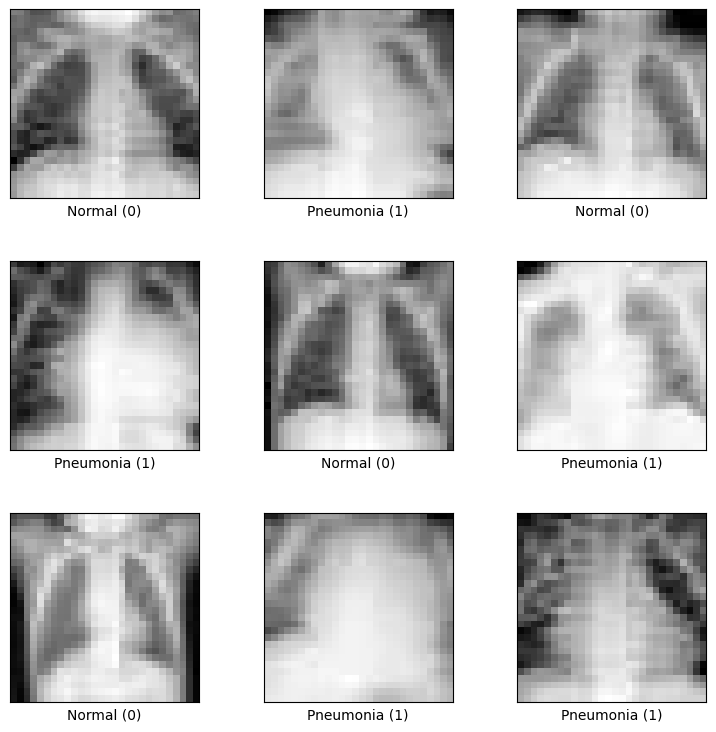

In [3]:
import tensorflow_datasets as tfds
ds, ds_info = tfds.load('pneumonia_mnist', with_info=True)
fig = tfds.show_examples(ds['train'], ds_info)

## Dataset Creation

Reformatting the dataset to be compatible with our XGBoost model & sklearn.

In [4]:
x_train = []
y_train = []
for example in ds['train']:
    x_train.append(example['image'].numpy().flatten())
    y_train.append(example['label'].numpy())

x_test = []
y_test = []
for example in ds['test']:
    x_test.append(example['image'].numpy().flatten())
    y_test.append(example['label'].numpy())

2025-05-29 12:11:31.625271: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## XGBoost Classifier (Default Parameters)

Let's first test XGBoost with default parameters. As you can see, we get about 85% accuracy and 0.81 AUC out of the box in predicting pneumonia in images.


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [6]:
model = XGBClassifier(random_state = 2025)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_pred), 2))

Accuracy: 0.85
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.63      0.76       234
           1       0.82      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.85      0.84       624

ROC AUC Score: 0.81


## Grid Search

Now let's see if we can find **better** hyperparameters. We will train another set of XGBoost models and we will use the `GridSearchCV` function from `sklearn.model_selection` to perform a grid search and cross-validation.

As you will see, we improve our accuracy to about 95% and ROC-AUC close to 0.99 by finding better hyperparameters. The grid search will run in parallel across all available CPU cores. 


In [7]:
param_grid = {
    'n_estimators': [2, 50, 100],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [5, 7],
    'colsample_bytree': [0.3, 0.9],
    'subsample': [0.2, 0.9]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

model = XGBClassifier(random_state=2025)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

### Visualization

Parallel coordinates plots are a great way to visualize the results of a grid search. We can see how the different hyperparameters affect the model's performance. The green lines represent the best performing models, while the red lines represent the worst performing models.

In [11]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Collect the results from the grid search.
results = pd.DataFrame(grid_search.cv_results_)

# Add a small amount of noise for better visualization.
jitter = lambda x: x + np.random.normal(0, 0.01 * x.max(), size=x.shape)
results['param_n_estimators'] = jitter(results['param_n_estimators'].astype(float))
results['param_learning_rate'] = jitter(results['param_learning_rate'].astype(float))
results['param_max_depth'] = jitter(results['param_max_depth'].astype(float))
results['param_colsample_bytree'] = jitter(results['param_colsample_bytree'].astype(float))
results['param_subsample'] = jitter(results['param_subsample'].astype(float))

# Plot a parallel coordinates plot.
fig = px.parallel_coordinates(
    results,
    dimensions=['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_colsample_bytree', 'param_subsample', 'mean_test_score'],
    color='mean_test_score',
    color_continuous_scale=px.colors.sequential.Turbo_r,
    labels={
        'param_n_estimators': 'Number of Estimators',
        'param_learning_rate': 'Learning Rate',
        'param_max_depth': 'Max Depth',
        'param_colsample_bytree': 'Colsample by Tree',
        'param_subsample': 'Subsample',
        'mean_test_score': 'Mean Test Score'
    },
)

fig.show()

## Random Search

Grid search can be exceptionally time consuming. Now we can train a new group of XGBoost classifiers using a random search over the same set of hyperparameters. We will use the `RandomizedSearchCV` function from `sklearn.model_selection` to perform a random search and cross-validation. Random search can be much faster than grid search, since you choose how many sampled parameters to run.

In our case, we get the same accuracy & AUC as grid search, but in a fraction of the time.

In [12]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = XGBClassifier(random_state=2025)
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)
random_search.fit(x_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

In [14]:
results = pd.DataFrame(random_search.cv_results_)

# Add a small amount of noise.
jitter = lambda x: x + np.random.normal(0, 0.01 * x.max(), size=x.shape)
results['param_n_estimators'] = jitter(results['param_n_estimators'].astype(float))
results['param_learning_rate'] = jitter(results['param_learning_rate'].astype(float))
results['param_max_depth'] = jitter(results['param_max_depth'].astype(float))
results['param_colsample_bytree'] = jitter(results['param_colsample_bytree'].astype(float))
results['param_subsample'] = jitter(results['param_subsample'].astype(float))

# Plot a parallel coordinates plot
fig = px.parallel_coordinates(
    results,
    dimensions=['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_colsample_bytree', 'param_subsample', 'mean_test_score'],
    color='mean_test_score',
    color_continuous_scale=px.colors.sequential.Turbo_r,
    labels={
        'param_n_estimators': 'Number of Estimators',
        'param_learning_rate': 'Learning Rate',
        'param_max_depth': 'Max Depth',
        'param_colsample_bytree': 'Colsample by Tree',
        'param_subsample': 'Subsample',
        'mean_test_score': 'Mean Test Score'
    },
)

fig.show()

## Conclusion

As you can see, random search is faster than grid search and in our case, still finds the best hyperparameters. However, grid search is more exhaustive and may find better hyperparameters in some cases. The choice between grid search and random search depends on the specific problem and the available computational resources. If both are inadequate, you can also use Hyperband or another more sophisticated hyperparameter optimization technique.